In [1]:
import numpy as np
import math
import pandas as pd
from scipy.stats import ks_2samp
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from scipy.sparse.csgraph import connected_components
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
# Simulation parameters
sigma = 1 #particle diameter
r_cutoff = (2**-6)*sigma #interaction cutoff
epsilon = 1e-23 #interaction strength
v = 60 #self-propulsion
lambda_tumble = 0.9 #tumble rate
lambda_run = lambda_tumble
num_steps = 100000 #number of steps in a simulations #change to 5000000 to match project parameters
T = 5 #final time
num_particles = 4 #number of particles
dt = 1e-5#T / num_steps #timestep
bounds = int(num_particles/0.65) #bounds of the 1d box, maintains fixed packing fraction

In [3]:
#Simulation functions

def update_x(x, rho, v, dt, f, bounds):
    """
    Update position based on velocity, run/tumble state, and force.
    Applies periodic boundary conditions.
    """
    x_new = x + rho * v * dt - f*dt
    x_new = x_new % bounds  # Apply periodic boundary conditions
    return x_new

#removed the negative signs from force in above and below equations
def calculate_force(epsilon, xi, xj, sigma, r_cutoff, bounds):
    """
    Calculate force between two particles using the WCA potential.
    """
    dx = xi - xj
    dx = dx - np.round(dx / bounds) * bounds  # Apply periodic boundary conditions
    r_ij = np.abs(dx)
    r_min = 0.5*r_cutoff*2**3

    if r_ij < r_cutoff:
        if r_ij <= r_min:
            force = (24 * epsilon / r_min) * (2 * (sigma / r_min)**12 - (sigma / r_min)**6)
            potential = (4 * epsilon ) * ( (sigma / r_min)**12 - (sigma / r_min)**6) + epsilon
        else:
            force = (24 * epsilon / r_ij) * (2 * (sigma / r_ij)**12 - (sigma / r_ij)**6)
            potential = (4 * epsilon ) * ( (sigma / r_ij)**12 - (sigma / r_ij)**6) + epsilon
    else:
        force, potential = 0.0, 0.0

    return force, potential

def run_or_tumble(state, lambda_run, lambda_tumble, current_time, last_switch_time):
    """
    Decide whether the particle continues its current state (run or tumble)
    or switches based on the exponential distribution.
    """
    if state == 1:  # Running
        duration = np.random.exponential(1 / lambda_run)
    else:  # Tumbling
        duration = np.random.exponential(1 / lambda_tumble)

    if current_time - last_switch_time >= duration:
        state = -state  # Toggle state
        last_switch_time = current_time  # Update the last switch time

    return state, last_switch_time

def enforce_minimum_distance(x_new, positions, i, sigma, bounds):
    """
    Enforce minimum distance so no exploding interactions due to division by zero.
    """
    for k, xk in enumerate(positions):
        if k != i:
            dx = x_new - xk
            dx = dx - np.round(dx / bounds) * bounds  # Apply periodic boundary conditions
            r_ij = np.abs(dx)
            packing_factor = 0.09
            r_min = 0.5 * sigma * packing_factor #minimum distance to avoid divison by zero
            if r_ij < r_min:
                if dx > 0:
                    x_new = xk + r_min
                else:
                    x_new = xk - r_min
                x_new = x_new % bounds  # Ensure periodic boundary conditions
    return x_new

In [4]:
#simulation set-up
positions = np.zeros([num_steps, num_particles])
positions[0, :] = positions[0, :] = np.linspace(0.5, bounds-0.5, num_particles) #np.random.uniform(0, bounds, num_particles)  # Initial positions
force = np.zeros([num_steps, num_particles])
potential = np.zeros([num_steps, num_particles])

# Initialize run/tumble states and switch times for each particle
states = np.ones(num_particles)  # Start all particles in "run" state
last_switch_times = np.zeros(num_particles)  # Initialize last switch times

# Initialize variables for run/tumble durations
run_durations = [[] for _ in range(num_particles)]
tumble_durations = [[] for _ in range(num_particles)]
state_start_times = np.zeros(num_particles)  # Start time for the current state

In [5]:
# Main simulation loop with additional tracking
for j in range(num_steps - 1):
    current_time = j * dt  # Calculate current time
    for i in range(num_particles):
        # Update run/tumble state for the particle
        prev_state = states[i]
        states[i], last_switch_times[i] = run_or_tumble(
            states[i], lambda_run, lambda_tumble, current_time, last_switch_times[i]
        )
        rho = states[i]

        # Update run/tumble durations
        if states[i] != prev_state:  # State change occurred
            duration = current_time - state_start_times[i]
            if prev_state == 1:  # Previous state was "run"
                run_durations[i].append(duration)
            else:  # Previous state was "tumble"
                tumble_durations[i].append(duration)
            state_start_times[i] = current_time  # Update start time for the new state

        # Calculate forces between particles
        force[j, i] = 0  # Reset force for particle i
        potential[j, i] = 0

        for k in range(num_particles):
            if k != i:
                f_wca, potential_wca = calculate_force(epsilon, positions[j, i], positions[j, k], sigma, r_cutoff, bounds)

                force[j, i] += (f_wca*dt)
                potential[j,i] += (potential_wca*dt)


        # Update particle position
        x_new = update_x(positions[j, i], rho, v, dt, force[j, i], bounds)

        # Enforce no overlap condition
        x_new = enforce_minimum_distance(x_new, positions[j, :], i, sigma, bounds)

        # Store the updated position
        positions[j + 1, i] = x_new


# Finalize results
run_durations = [np.array(durations) for durations in run_durations]
tumble_durations = [np.array(durations) for durations in tumble_durations]

In [6]:
# Prepare Data for Animation
animation_data = []

for step in range(num_steps):
    frame_data = pd.DataFrame({
        'X': positions[step, :],
        'Y': np.zeros(num_particles),  # If only 1D, we can place them along Y=0
        'Particle': np.arange(num_particles),
        'Size': [sigma] * num_particles,  # Scale size for visualization
    })
    frame_data['Time'] = step  # To enable smooth transition over time
    animation_data.append(frame_data)

df = pd.concat(animation_data).reset_index(drop=True)
df["Particle"] = df["Particle"].astype(str)

# Create Animation
size_ref = sigma * 7  # Adjust size scaling for better visualization
fig = px.scatter(
    df.tail(1000), #remove .tail(..) if you want to start from t=0, BE WARNED that the animation is intensive so run for varying parameters carefully
    x='X', y='Y', animation_frame='Time',
    size='Size', size_max=size_ref,
    title='Particle Simulation Animation',
    range_x=[0, bounds], range_y=[-2, 2],  # Adjust Y-axis range for better 1D visualization
    labels={'X': 'X Position', 'Y': 'Y Position'},
    #color = 'Particle'
)

# Add boundary box for periodic conditions
fig.add_shape(
    type="rect", x0=0, y0=-bounds/8, x1=bounds, y1=bounds/8,
    line=dict(color="black", width=2),
)

# Update layout
fig.update_layout(
    width=1000,
    height=800,
    yaxis_scaleanchor="x",
    title_text="1D Particle Motion with Periodic Boundaries",
    title_x=0.5,
)

# Show the animation
#fig.show()

In [7]:
#Positions
a,b = positions.shape
list_positions = []

for i in range(b):
    # Create a DataFrame with X positions for each time step (i-th time step)
    positionsDf = pd.DataFrame(data=positions[:, i], columns=['X'])

    # Calculate the squared differences in the X direction
    xDiff = positionsDf['X'] - positionsDf.at[0, 'X']
    xDiffWrapped = bounds - np.abs(xDiff)  # Calculate the wrapped distance
    positionsDf['xDiffSquared'] = np.minimum(xDiff**2, xDiffWrapped**2)  # Take the minimum of direct and wrapped squared distances
    positionsDf['MSD'] = np.sqrt(positionsDf['xDiffSquared'])
    positionsDf["dt"] = dt
    positionsDf["time"] = positionsDf['dt'].cumsum()
    positionsDf["Particle"] = i
    positionsDf["shift_1"] = positionsDf["X"].shift(1)
    positionsDf.at[0,"shift_1"] = 0

    # Append the result for the current time step
    list_positions.append(positionsDf)
distance = pd.concat(list_positions).reset_index(drop=True)

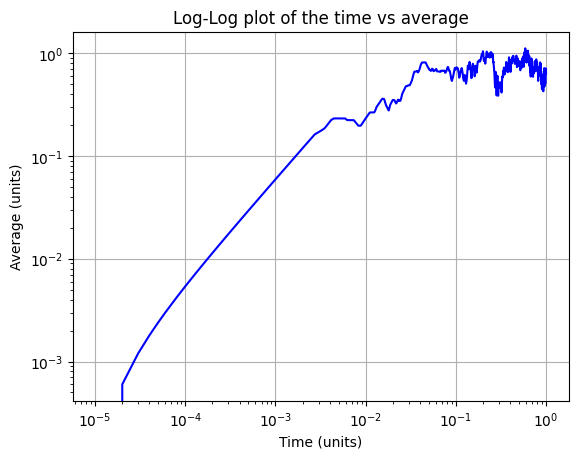

In [8]:
#MSD
msd = distance.groupby("time").mean()["MSD"].reset_index()
plt.loglog(msd['time'],msd['MSD'], linestyle='-', color='b')
plt.title('Log-Log plot of the time vs average')
plt.xlabel('Time (units)')
plt.ylabel('Average (units)')
plt.grid(True)
plt.show();

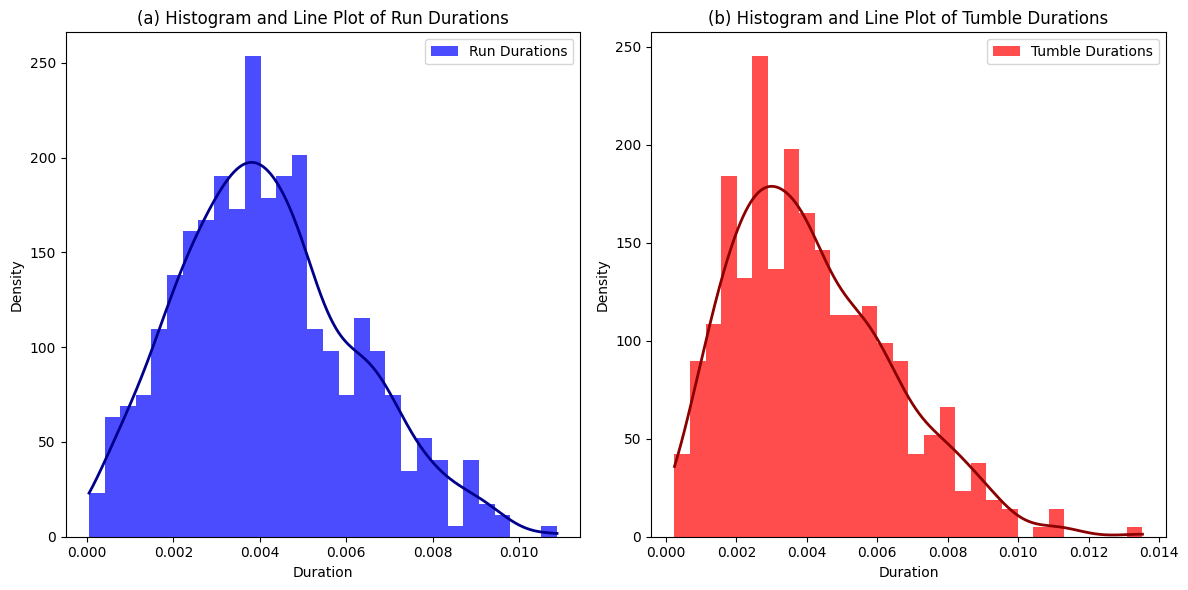

In [9]:
# Flatten the lists of durations to create a combined histogram
all_run_durations = np.concatenate(run_durations)
all_tumble_durations = np.concatenate(tumble_durations)

# Calculate Kernel Density Estimate (KDE) for smoother line plots
kde_run = gaussian_kde(all_run_durations)
kde_tumble = gaussian_kde(all_tumble_durations)

# Define a range for the x-axis based on data
x_run = np.linspace(min(all_run_durations), max(all_run_durations), 1000)
x_tumble = np.linspace(min(all_tumble_durations), max(all_tumble_durations), 1000)

# Plot histograms with line plots
plt.figure(figsize=(12, 6))

# Histogram and KDE for run durations
plt.subplot(1, 2, 1)
plt.hist(all_run_durations, bins=30, color='blue', alpha=0.7, label='Run Durations', density=True)
plt.plot(x_run, kde_run(x_run), color='darkblue', lw=2)
plt.xlabel('Duration')
plt.ylabel('Density')
plt.title('(a) Histogram and Line Plot of Run Durations')
plt.legend()

# Histogram and KDE for tumble durations
plt.subplot(1, 2, 2)
plt.hist(all_tumble_durations, bins=30, color='red', alpha=0.7, label='Tumble Durations', density=True)
plt.plot(x_tumble, kde_tumble(x_tumble), color='darkred', lw=2)
plt.xlabel('Duration')
plt.ylabel('Density')
plt.title('(b) Histogram and Line Plot of Tumble Durations')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
distance_list = []
for i in range(num_particles):
  slice_dataset = distance[distance["Particle"] == i][["time","Particle","MSD"]].copy()
  slice_dataset["shift_1"] = slice_dataset["MSD"].shift(1)
  slice_dataset["MSD_potential"] = slice_dataset["MSD"]*v
  slice_dataset = slice_dataset.fillna(0)
  slice_dataset["potential_delta"] = np.abs(v*(slice_dataset["MSD"] - slice_dataset["shift_1"]))
  slice_dataset = slice_dataset[["time","Particle","MSD_potential","potential_delta"]]
  distance_list.append(slice_dataset)
distance_potential_dataset = pd.concat(distance_list,axis=0).reset_index(drop=True)


potential_list = []
for i in range(num_particles):
  potential_data = pd.DataFrame(data=potential[:,i], columns=["Energy"]) #chenged potential to force
  potential_data["Particle"] = i
  potential_data["time"] = distance["time"]
  potential_data["shift_1"] = potential_data["Energy"].shift(1)
  potential_data["wca_delta"] = (np.abs(potential_data["Energy"] - potential_data["shift_1"]))*1e12
  potential_data = potential_data[["time","Particle","Energy","wca_delta"]]
  potential_data = potential_data.fillna(0)
  potential_list.append(potential_data)


potential_df = pd.concat(potential_list,axis=0).reset_index(drop=True)

effective_potential_dataset = potential_df.merge(
    distance_potential_dataset,
    left_on = ["time","Particle"],
    right_on = ["time","Particle"],
    how = "inner"
)

effective_potential_dataset["wca_delta"] = np.where((effective_potential_dataset["time"] == 	dt) | (effective_potential_dataset["time"] == 2*dt),0,effective_potential_dataset["wca_delta"])
effective_potential_dataset["potential_delta"] = np.where((effective_potential_dataset["time"] == 	dt) | (effective_potential_dataset["time"] == 2*dt),0,effective_potential_dataset["potential_delta"])
effective_potential_dataset["effective_potential"] = effective_potential_dataset["wca_delta"] - effective_potential_dataset["potential_delta"]
effective_potential_dataset["shift_1"] = effective_potential_dataset["effective_potential"].shift(1)
effective_potential_dataset["effective_delta"] = effective_potential_dataset["effective_potential"] - effective_potential_dataset["shift_1"]
effective_potential_dataset["avalanching"] = np.where(effective_potential_dataset["effective_delta"] < 0, 1, 0)
effective_potential_dataset["avalanching"] = np.where((effective_potential_dataset["time"] == 2*dt) | (effective_potential_dataset["time"] == 3*dt), 0, effective_potential_dataset["avalanching"])
effective_potential_dataset = effective_potential_dataset.fillna(0)


avalanche_size_dataset = effective_potential_dataset.pivot(
    index = "time",
    columns = "Particle",
    values = "avalanching"
).reset_index().rename_axis(None, axis=1).set_index("time")
avalanche_size_dataset["avalanche_size"] = avalanche_size_dataset.sum(axis=1)
avalanche_size_dataset = avalanche_size_dataset.reset_index()
avalanche_size_dataset["avalanche_size"] = np.where(avalanche_size_dataset["time"] == dt, 0, avalanche_size_dataset["avalanche_size"])

#Two point correlation

# Filter and calculate time-averaged covariance
df = avalanche_size_dataset[avalanche_size_dataset["avalanche_size"] != 0].copy()
df['S_t'] = df['avalanche_size']
df['S_t+1'] = df['avalanche_size'].shift(-1)
df = df.dropna()

N = len(df)
mean_S_t = df['S_t'].sum() / N
mean_S_t_plus_1 = df['S_t+1'].sum() / N
mean_S_t_S_t_plus_1 = (df['S_t'] * df['S_t+1']).sum() / N

cov_S_t_S_t_plus_1 = mean_S_t_S_t_plus_1 - (mean_S_t * mean_S_t_plus_1)*2

plot_effective_potential = effective_potential_dataset.groupby("time").sum().reset_index().copy()
plot_effective_potential["effective_delta"] = np.where(plot_effective_potential["time"] == dt,0,plot_effective_potential["effective_delta"])
plot_effective_potential["avalanching"] = np.where(plot_effective_potential["time"] == dt,0,plot_effective_potential["avalanching"])
plot_effective_potential = plot_effective_potential[["time","effective_delta","avalanching"]]

In [11]:
avalanches = avalanche_size_dataset[["time","avalanche_size"]].copy()
avalanches = avalanches.rename(columns={"avalanche_size":"avalanche"})
avalanches["dt"] = dt

# Calculate the sum of dt for consecutive avalanche events
avalanche_rows = avalanches[avalanches['avalanche'] == 1]
avalanche_durations = []
current_duration = 0

for idx, row in avalanche_rows.iterrows():
    # Add dt to the current duration if it's part of the avalanche
    current_duration += row['dt']

    # If the next row doesn't have avalanche = 1, save the current duration and reset
    if idx + 1 not in avalanche_rows.index:
        avalanche_durations.append(current_duration)
        current_duration = 0  # Reset for next avalanche

In [12]:
print(f'Average Avalanche Size: {avalanche_size_dataset["avalanche_size"].mean()}')
print(f'Average Avalanche Duration: {np.mean(avalanche_durations)}')
print(f'Two-Point Correlation: {cov_S_t_S_t_plus_1}')

Average Avalanche Size: 0.28624
Average Avalanche Duration: 1.0762111701271528e-05
Two-Point Correlation: -1.0699573385236207


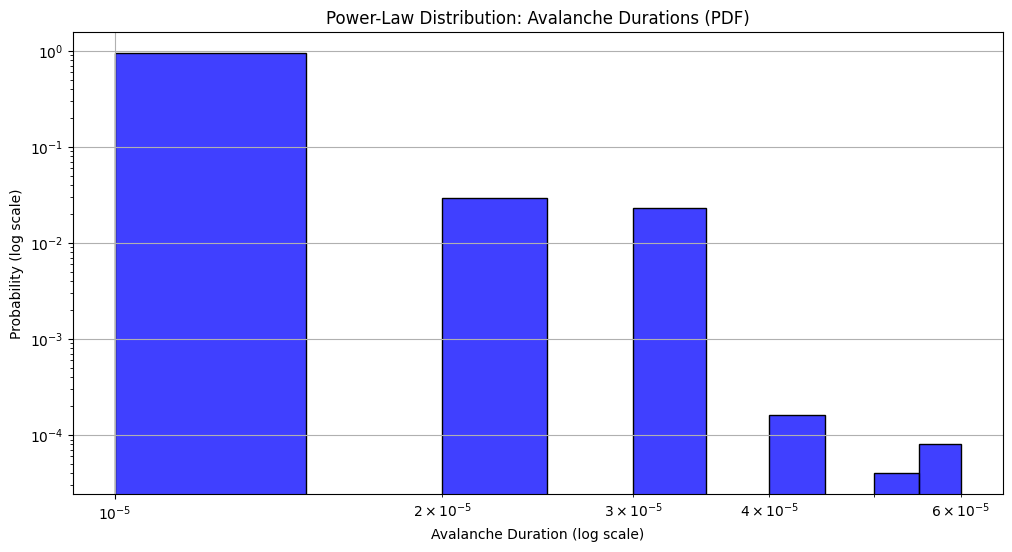

In [13]:
# PDF plot (Probability Distribution Function) on a log-log scale
plt.figure(figsize=(12, 6))

# Plot PDF on a log-log scale
sns.histplot(avalanche_durations, bins=10, kde=False, stat="probability", color='blue')
plt.xscale('log')
plt.yscale('log')
plt.title('Power-Law Distribution: Avalanche Durations (PDF)')
plt.xlabel('Avalanche Duration (log scale)')
plt.ylabel('Probability (log scale)')
plt.grid(True)
plt.show()

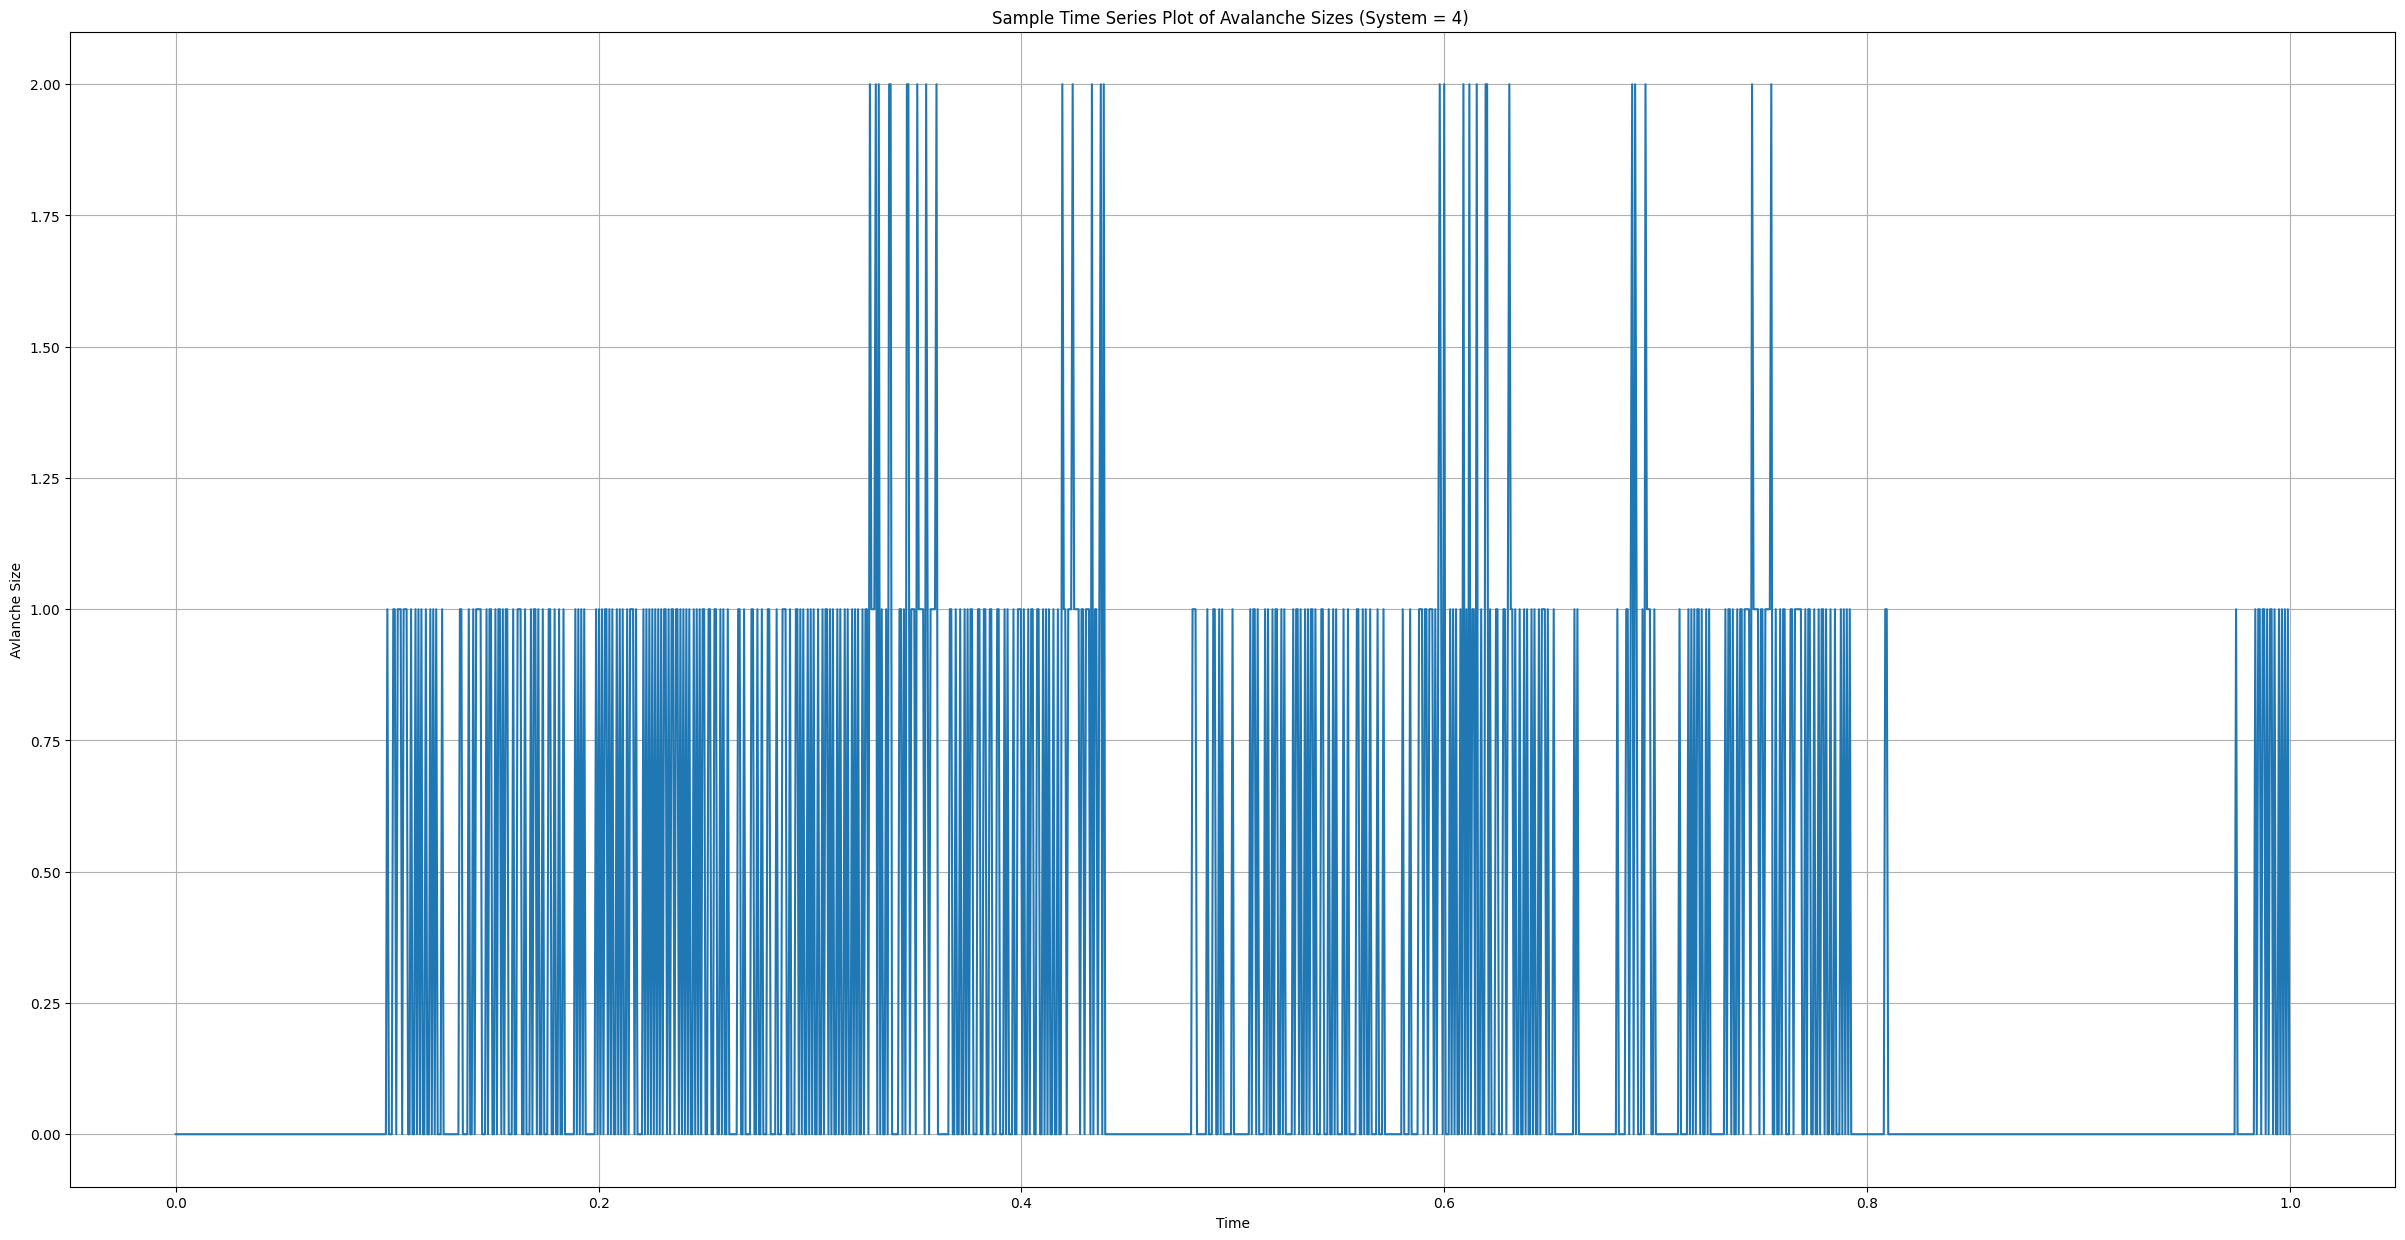

In [14]:
# PLot of Avalanche sizes the histogram
plot_avalanche_sizes = avalanche_size_dataset.copy()
plot_avalanche_sizes["avalanche_size"] = np.where(plot_avalanche_sizes["time"] < 0.1, 0,plot_avalanche_sizes["avalanche_size"])
plot_avalanche_sizes = plot_avalanche_sizes[["time","avalanche_size"]]


plt.figure(figsize=(30, 15))
skip = 70
subset_time = plot_avalanche_sizes["time"][::skip]  # Select every 100th time value
subset_avalanche_size = plot_avalanche_sizes["avalanche_size"][::skip]  # Select every 100th avalanche size
plt.plot(subset_time,subset_avalanche_size)#,linewidth=0.8)

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Avlanche Size")
plt.title(f"Sample Time Series Plot of Avalanche Sizes (System = {num_particles}) ")
plt.grid(True)

# Show the plot
plt.show()

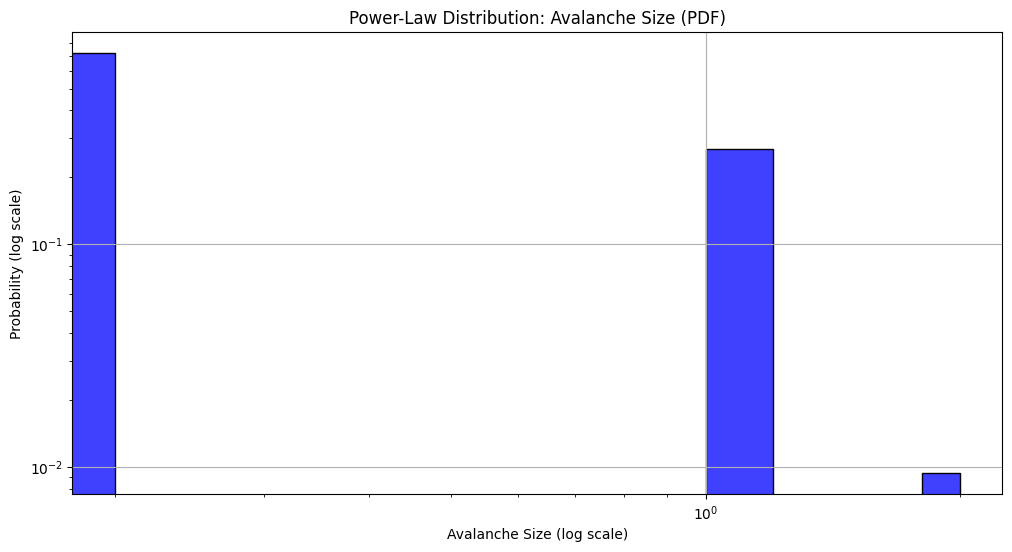

In [15]:
plt.figure(figsize=(12, 6))

# Plot PDF on a log-log scale
sns.histplot(avalanche_size_dataset["avalanche_size"], bins=10, kde=False, stat="probability", color='blue')
plt.xscale('log')
plt.yscale('log')
plt.title('Power-Law Distribution: Avalanche Size (PDF)')
plt.xlabel('Avalanche Size (log scale)')
plt.ylabel('Probability (log scale)')
plt.grid(True)
plt.show()

In [16]:
avalanche_sizes = avalanche_size_dataset[avalanche_size_dataset["avalanche_size"] != 0].copy()

# Define bins
bins = np.logspace(np.log10(min(avalanche_sizes["avalanche_size"])), np.log10(max(avalanche_sizes["avalanche_size"])), num=6)

# Compute histogram and normalize
hist, bin_edges = np.histogram(avalanche_sizes["avalanche_size"], bins=bins, density=True)

# Calculate bin centers for plotting
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])



# Define a power-law function for fitting
def power_law(x, tau, A):
    return A * x**(-tau)

# Fit the power-law region
scaling_region = bin_centers < np.percentile(bin_centers, 95)  # Fit up to 90% of data

# Estimate the characteristic avalanche size (s_c)
s_c = bin_centers[np.argmax(hist * (bin_centers >= np.percentile(bin_centers, 90)))]
print(f"Characteristic avalanche size (s_c): {s_c}")

Characteristic avalanche size (s_c): 1.8705505632961241


In [17]:
# Initialize an empty list to store results
cluster_results = []

# Iterate over each time step
for time, group in distance.groupby("time"):
    # Extract particle positions from the 'Position' column
    positions = group[["X"]].values  # Assuming 'Position' contains the position data

    # Compute pairwise distances between particles
    distances = squareform(pdist(positions, metric="euclidean"))

    # Create adjacency matrix (1 if distance <= r_cutoff, else 0)
    adjacency_matrix = (distances <= r_cutoff+0.045).astype(int)

    # Use scipy's connected_components to find clusters
    n_clusters, labels = connected_components(adjacency_matrix, directed=False)

    # Append results for all particles at this time step
    cluster_results.extend(
        {"time": time, "Particle": particle, "Cluster": cluster}
        for particle, cluster in zip(group["Particle"], labels)
    )

In [18]:
cluster_df = pd.DataFrame(cluster_results)
# Group by time and cluster to calculate cluster sizes
cluster_sizes = cluster_df.groupby(["time", "Cluster"]).size().reset_index(name="ClusterSize")

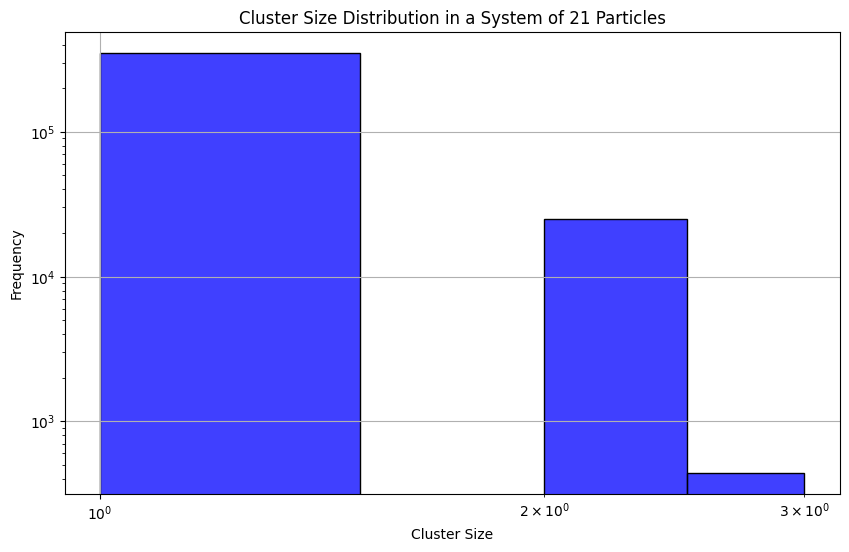

In [19]:
#Distribution of Cluster Sizes

plt.figure(figsize=(10, 6))

# Plot a histogram on a log-log scale
sns.histplot(cluster_sizes["ClusterSize"], bins=4, kde=False, color="blue", edgecolor="black")
plt.xscale('log')
plt.yscale('log')
# Add labels and title
plt.xlabel("Cluster Size")
plt.ylabel("Frequency")
plt.title("Cluster Size Distribution in a System of 21 Particles")
plt.grid(True)

plt.show()

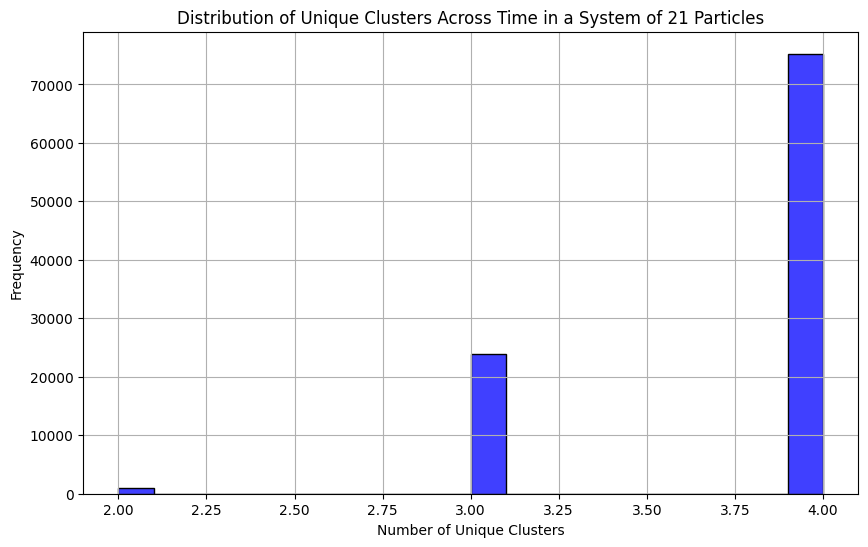

In [20]:
# Count unique clusters per time step
unique_clusters_per_time = cluster_df.groupby("time")["Cluster"].nunique().reset_index(name="UniqueClusters")


plt.figure(figsize=(10, 6))

# Plot a histogram of unique clusters
sns.histplot(unique_clusters_per_time["UniqueClusters"], bins=20, kde=False, color="blue")
# plt.xscale('log')
# plt.yscale('log')
# Add labels and title
plt.xlabel("Number of Unique Clusters")
plt.ylabel("Frequency")
plt.title("Distribution of Unique Clusters Across Time in a System of 21 Particles")
plt.grid(True)


plt.show()